In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image

In [2]:
TRAINING_PATH = "/content/drive/MyDrive/Dataset/Training_image"
TESTING_PATH = "/content/drive/MyDrive/Dataset/Testing_image"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
IMG_CHANNEL = 3

MAX_SIZEX = 2048
MAX_SIZEY = 2048

gpu = torch.device('cuda')
cpu = torch.device('cpu')

# Importing Image For Training

In [5]:
img_folder_lst = []
with os.scandir(TRAINING_PATH) as entries:
    for entry in entries:
        img_folder_lst.append(entry.name)

In [6]:
x_train = np.zeros((len(img_folder_lst), IMG_CHANNEL, MAX_SIZEX, MAX_SIZEY), dtype=np.uint8)
y_train = np.zeros((len(img_folder_lst), 1, MAX_SIZEX, MAX_SIZEY), dtype=np.uint8)

print(x_train.shape)
print(y_train.shape)

(20, 3, 2048, 2048)
(20, 1, 2048, 2048)


In [7]:
def read_xtrain_image(path):
    rgba_img = Image.open(path)
    rgb_img = rgba_img.convert('RGB')

    img_arr = np.array(rgb_img)
    img_arr = np.transpose(img_arr, (2, 0, 1))
    img_arr = np.pad(img_arr, ((0, 0), (0, MAX_SIZEX - img_arr.shape[1]), (0, MAX_SIZEY - img_arr.shape[2])), 'constant')

    return img_arr

def read_ytrain_image(path):
    expanded_img = np.zeros((1, MAX_SIZEX, MAX_SIZEY), dtype= np.uint8)
    combine_img = 0
    with os.scandir(path) as entries:
        for entry in entries:
            bin_img = Image.open(path + "/" + entry.name)

            img_arr = np.array(bin_img)
            combine_img = img_arr | combine_img

    combine_img = np.pad(combine_img, ((0, MAX_SIZEX - combine_img.shape[0]), (0, MAX_SIZEY - combine_img.shape[1])), 'constant')

    combine_img[combine_img == 255] = 1
    
    expanded_img[0] = combine_img

    return expanded_img

In [8]:
parentFolder = TRAINING_PATH + "/"

for idx, name in enumerate(img_folder_lst):
    path = parentFolder + name + "/images/" + name + ".png"

    x_train[idx] = read_xtrain_image(path)

    path = parentFolder + name + "/masks"

    y_train[idx] = read_ytrain_image(path)
    
    # if idx % 100 == 0:
    print("Done: ", idx)

Done:  0
Done:  1
Done:  2
Done:  3
Done:  4
Done:  5
Done:  6
Done:  7
Done:  8
Done:  9
Done:  10
Done:  11
Done:  12
Done:  13
Done:  14
Done:  15
Done:  16
Done:  17
Done:  18
Done:  19


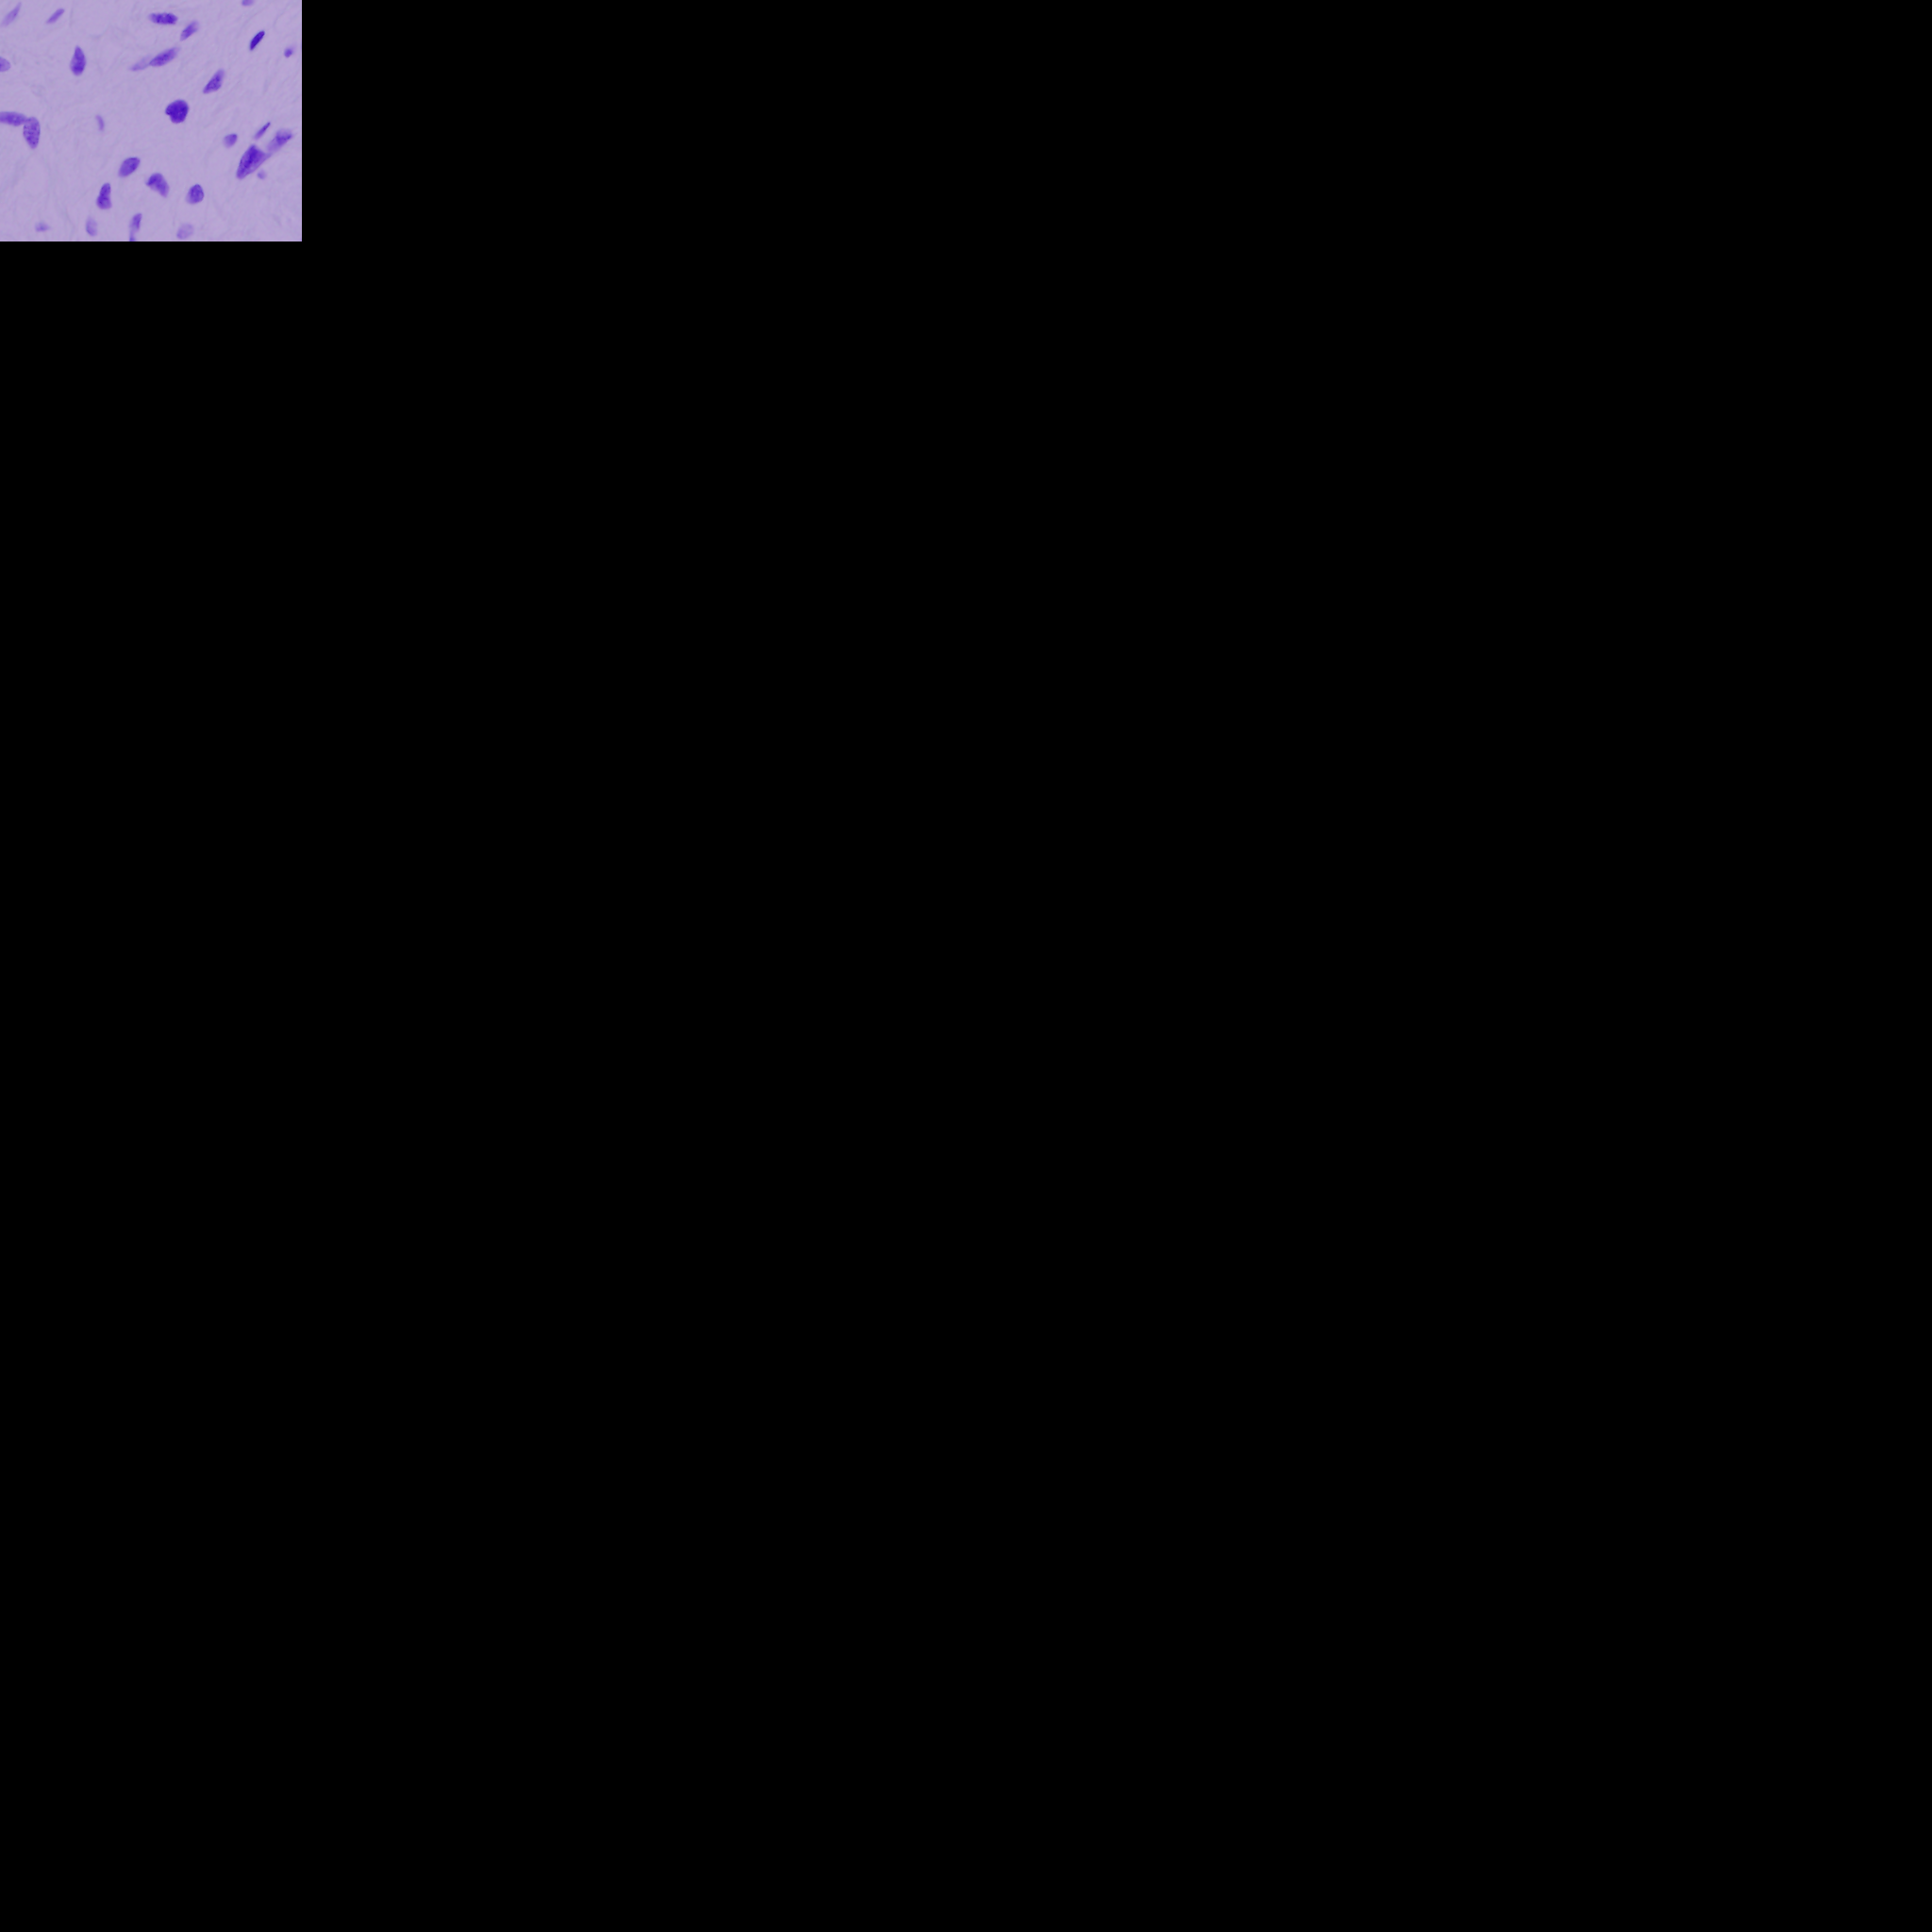

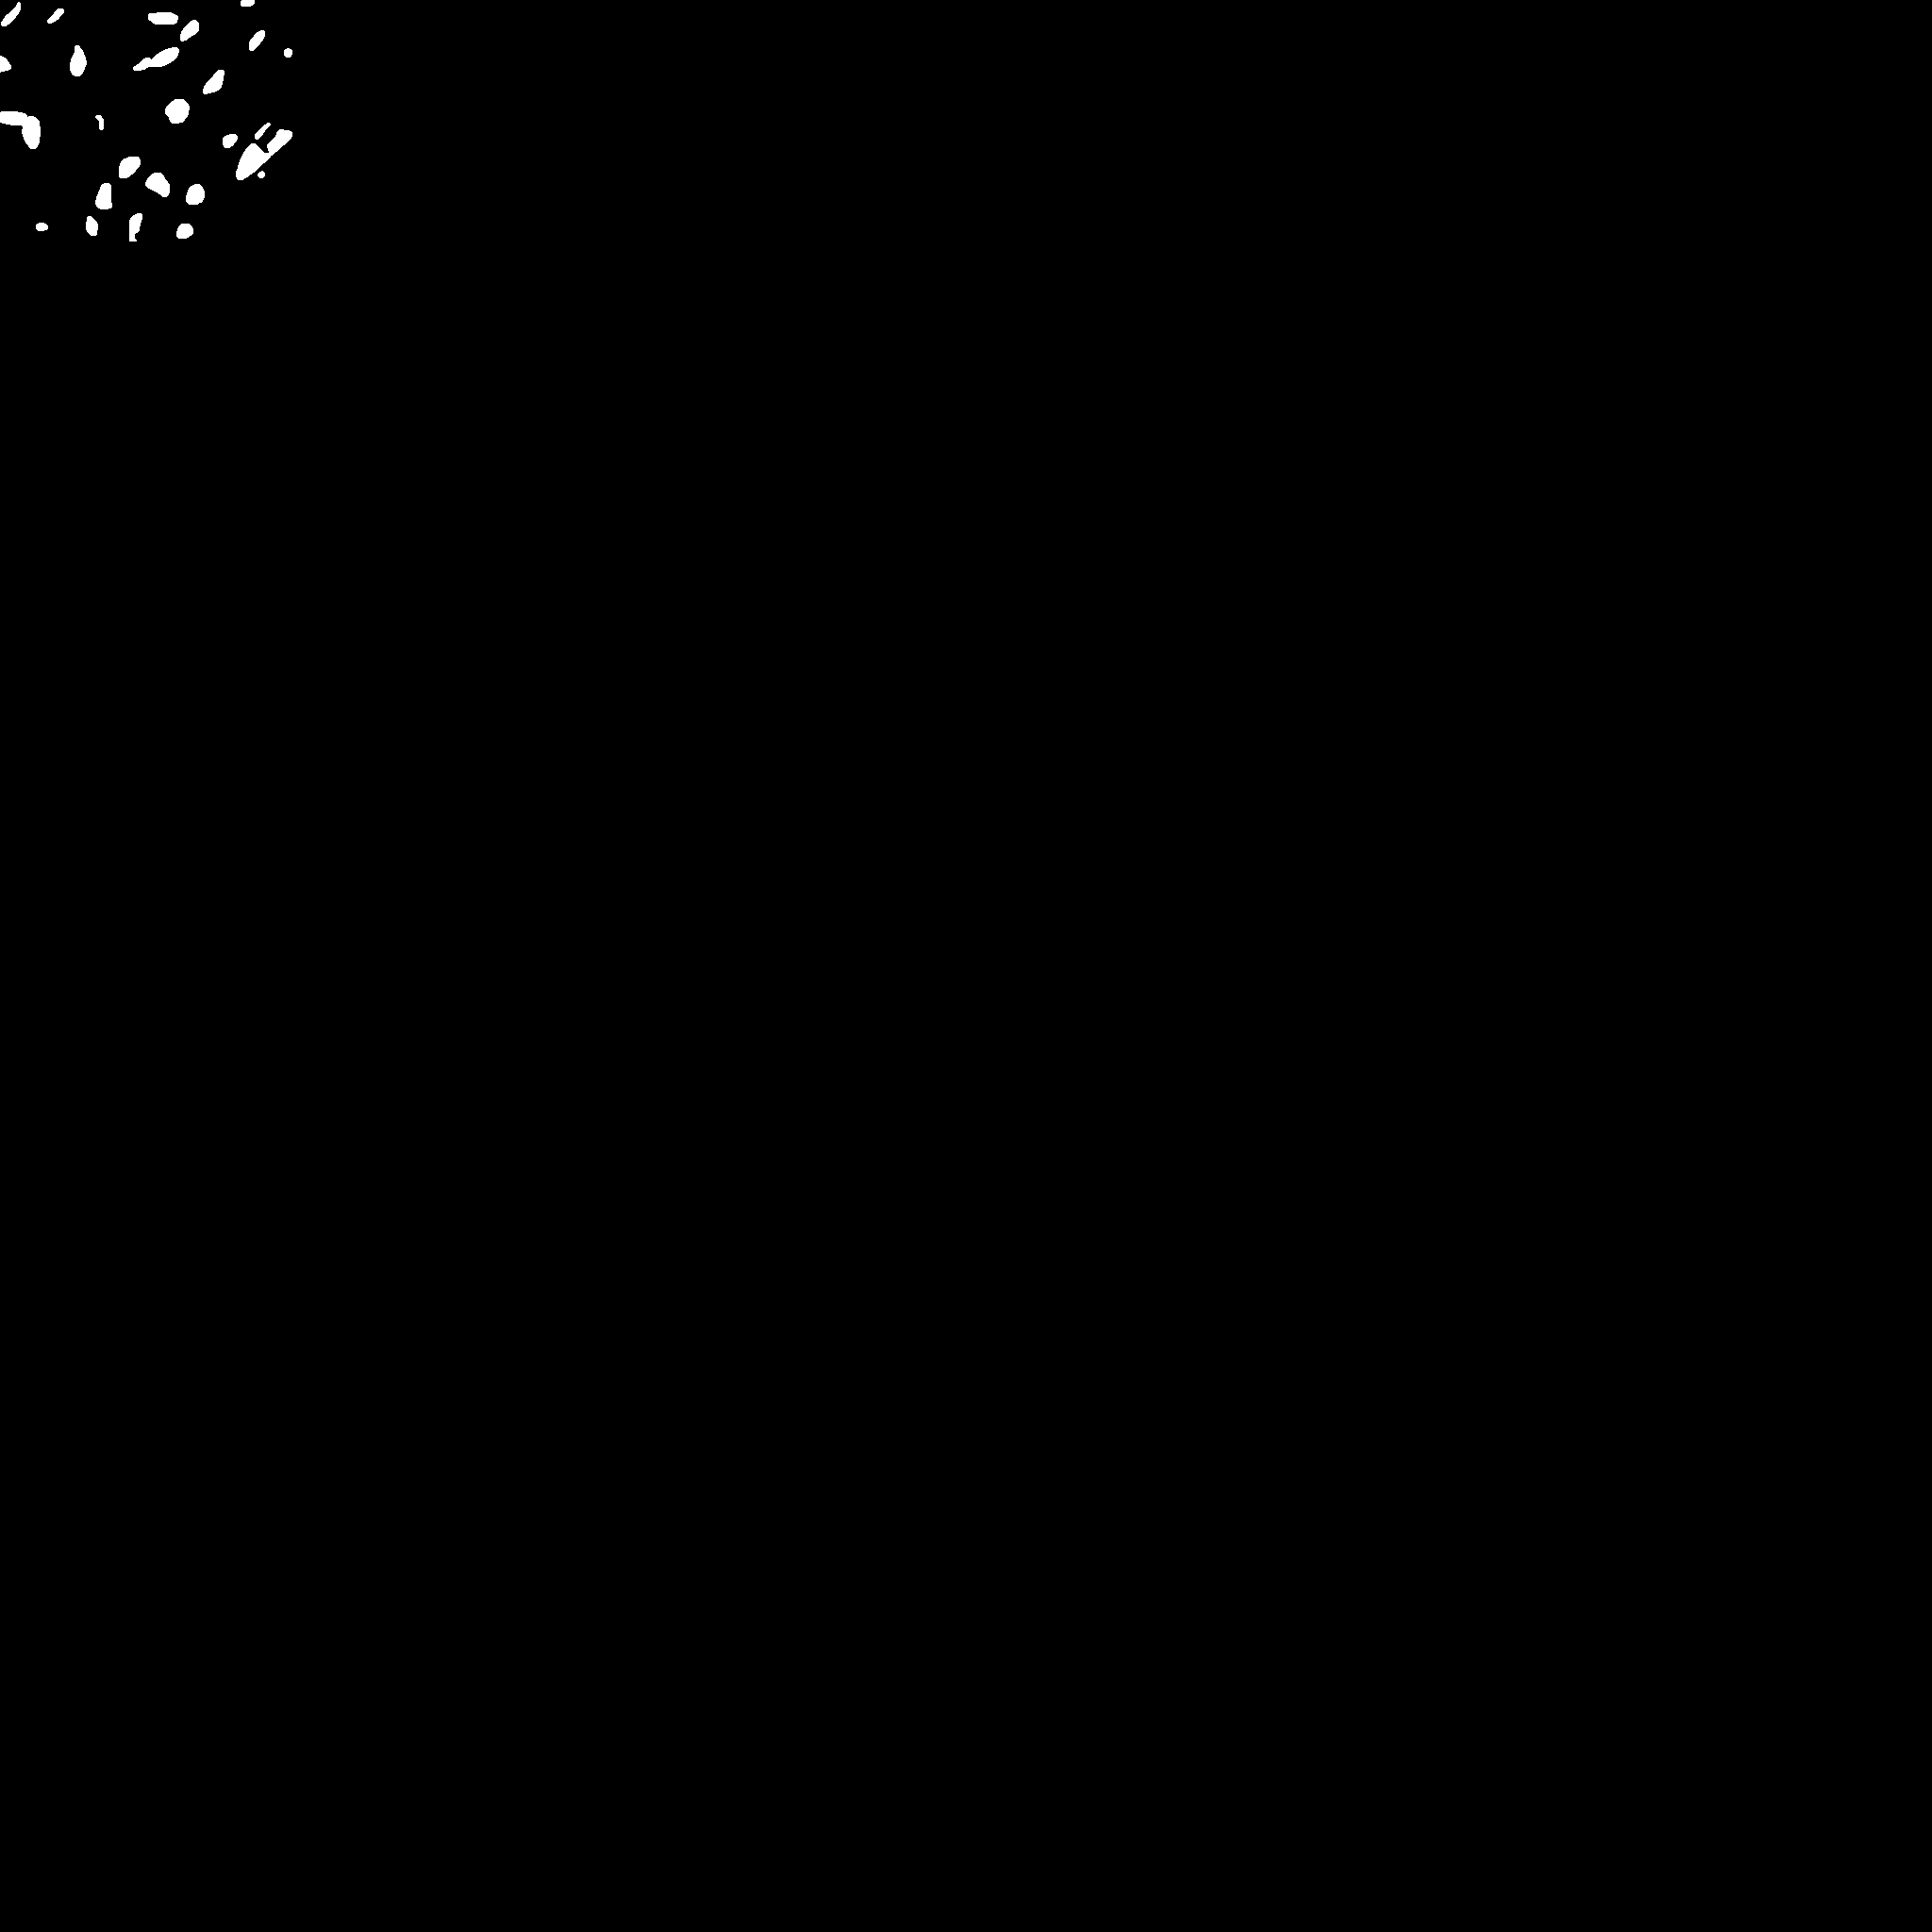

In [9]:
img = Image.fromarray(np.transpose(x_train[3], (1, 2, 0)))
img.show(title="Source")

test_y = np.array(y_train[3])
test_y[test_y == 1] = 255
img = Image.fromarray(test_y[0])
img.show(title = "Mask")

In [10]:
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

# Unet Model

In [11]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super(conv_block, self).__init__()
    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.relu = nn.ReLU()

  def forward(self, image):
    x = self.conv1(image)
    x = torch.unsqueeze(x, dim = 0)
    x = self.bn1(x)
    x = self.relu(x)

    x = torch.squeeze(x)
    x = self.conv2(x)

    x = torch.unsqueeze(x, dim = 0)
    x = self.bn2(x)
    x = self.relu(x)

    return torch.squeeze(x)

In [12]:
class encode_block(nn.Module):
  def __init__(self, in_c, out_c):
    super(encode_block, self).__init__()
    self.conv = conv_block(in_c, out_c)
    self.pooling = nn.MaxPool2d(2, 2)

  def forward(self, input):
    x = self.conv(input)
    pooled_x = self.pooling(x)

    return x, pooled_x

class decode_block(nn.Module):
  def __init__(self, in_c, out_c, upsampling_c):
    super(decode_block, self).__init__()
    self.conv = conv_block(in_c, out_c)
    self.upsampling = nn.ConvTranspose2d(out_c, upsampling_c, kernel_size = 2, stride = 2, padding = 0)

  def forward(self, input):
    x = self.conv(input)
    x = self.upsampling(x)

    return x

In [13]:
class Unet(torch.nn.Module):
    def __init__(self, input_channel) -> None:
        super(Unet, self).__init__()

        self.c1_channel = 6
        self.c2_channel = 12
        self.c3_channel = 24
        self.c4_channel = 48
        self.c5_channel = 96

        ### ENCODE SECTION ###
        self.encode1 = encode_block(input_channel, self.c1_channel)
        self.encode2 = encode_block(self.c1_channel, self.c2_channel)
        self.encode3 = encode_block(self.c2_channel, self.c3_channel)
        self.encode4 = encode_block(self.c3_channel, self.c4_channel)

        ### DECODE SECTION ###
        self.decode1 = decode_block(self.c4_channel, self.c5_channel, self.c4_channel)
        self.decode2 = decode_block(self.c5_channel, self.c4_channel, self.c3_channel)
        self.decode3 = decode_block(self.c4_channel, self.c3_channel, self.c2_channel)
        self.decode4 = decode_block(self.c3_channel, self.c2_channel, self.c1_channel)

        self.c9_1 = conv_block(self.c2_channel, self.c1_channel)
        self.c9_2 = nn.Conv2d(self.c1_channel, 2, kernel_size = 1, padding = 0)

        self.criteria = nn.CrossEntropyLoss()

    # Image có shape: (Batch Size, 3, SIZEX, SIZEY)
    def forward(self, image):

        x1, pooled_x1 = self.encode1(image)
        x2, pooled_x2 = self.encode2(pooled_x1)
        x3, pooled_x3 = self.encode3(pooled_x2)
        x4, pooled_x4 = self.encode4(pooled_x3)

        x5 = self.decode1(pooled_x4)
        concated_5 = torch.concatenate((x5, x4), dim = 0)

        x6 = self.decode2(concated_5)
        concated_6 = torch.concatenate((x6, x3), dim = 0)

        x7 = self.decode3(concated_6)
        concated_7 = torch.concatenate((x7, x2), dim = 0)

        x8 = self.decode4(concated_7)
        concated_8 = torch.concatenate((x8, x1), dim = 0)

        x9 = self.c9_1(concated_8)
        x10 = self.c9_2(x9)

        return x10

    def loss(self, conv_arr, mask):
        reshaped_unet = conv_arr.reshape(1, conv_arr.shape[0], conv_arr.shape[1], conv_arr.shape[2])

        return self.criteria(reshaped_unet, mask)

    # @image: (3, SIZEX, SIZEY)
    # @mask: (1, SIZEX, SIZEY)    
    def train_step(self, image, mask):
        unet_output = self.forward(image)
        return self.loss(unet_output, mask)

    def train_model(self, imgset, maskset, optimizer):
        x = imgset.to(gpu)
        y = maskset.to(gpu)

        optimizer.zero_grad()
        loss = 0
        for img_idx in range(x.shape[0]):
            loss += self.train_step(x[img_idx], y[img_idx])
        loss.backward()
        optimizer.step()

        return loss.item()

    def test_step(self, image):
        with torch.no_grad():
          unet_output = self.forward(image)
          softmax_output = torch.softmax(unet_output, dim = 0)

          output_mask = torch.max(softmax_output, dim = 0)[1]
          return output_mask.to(cpu)

# Training Model And Testing Model

In [14]:
model = Unet(input_channel=3).to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

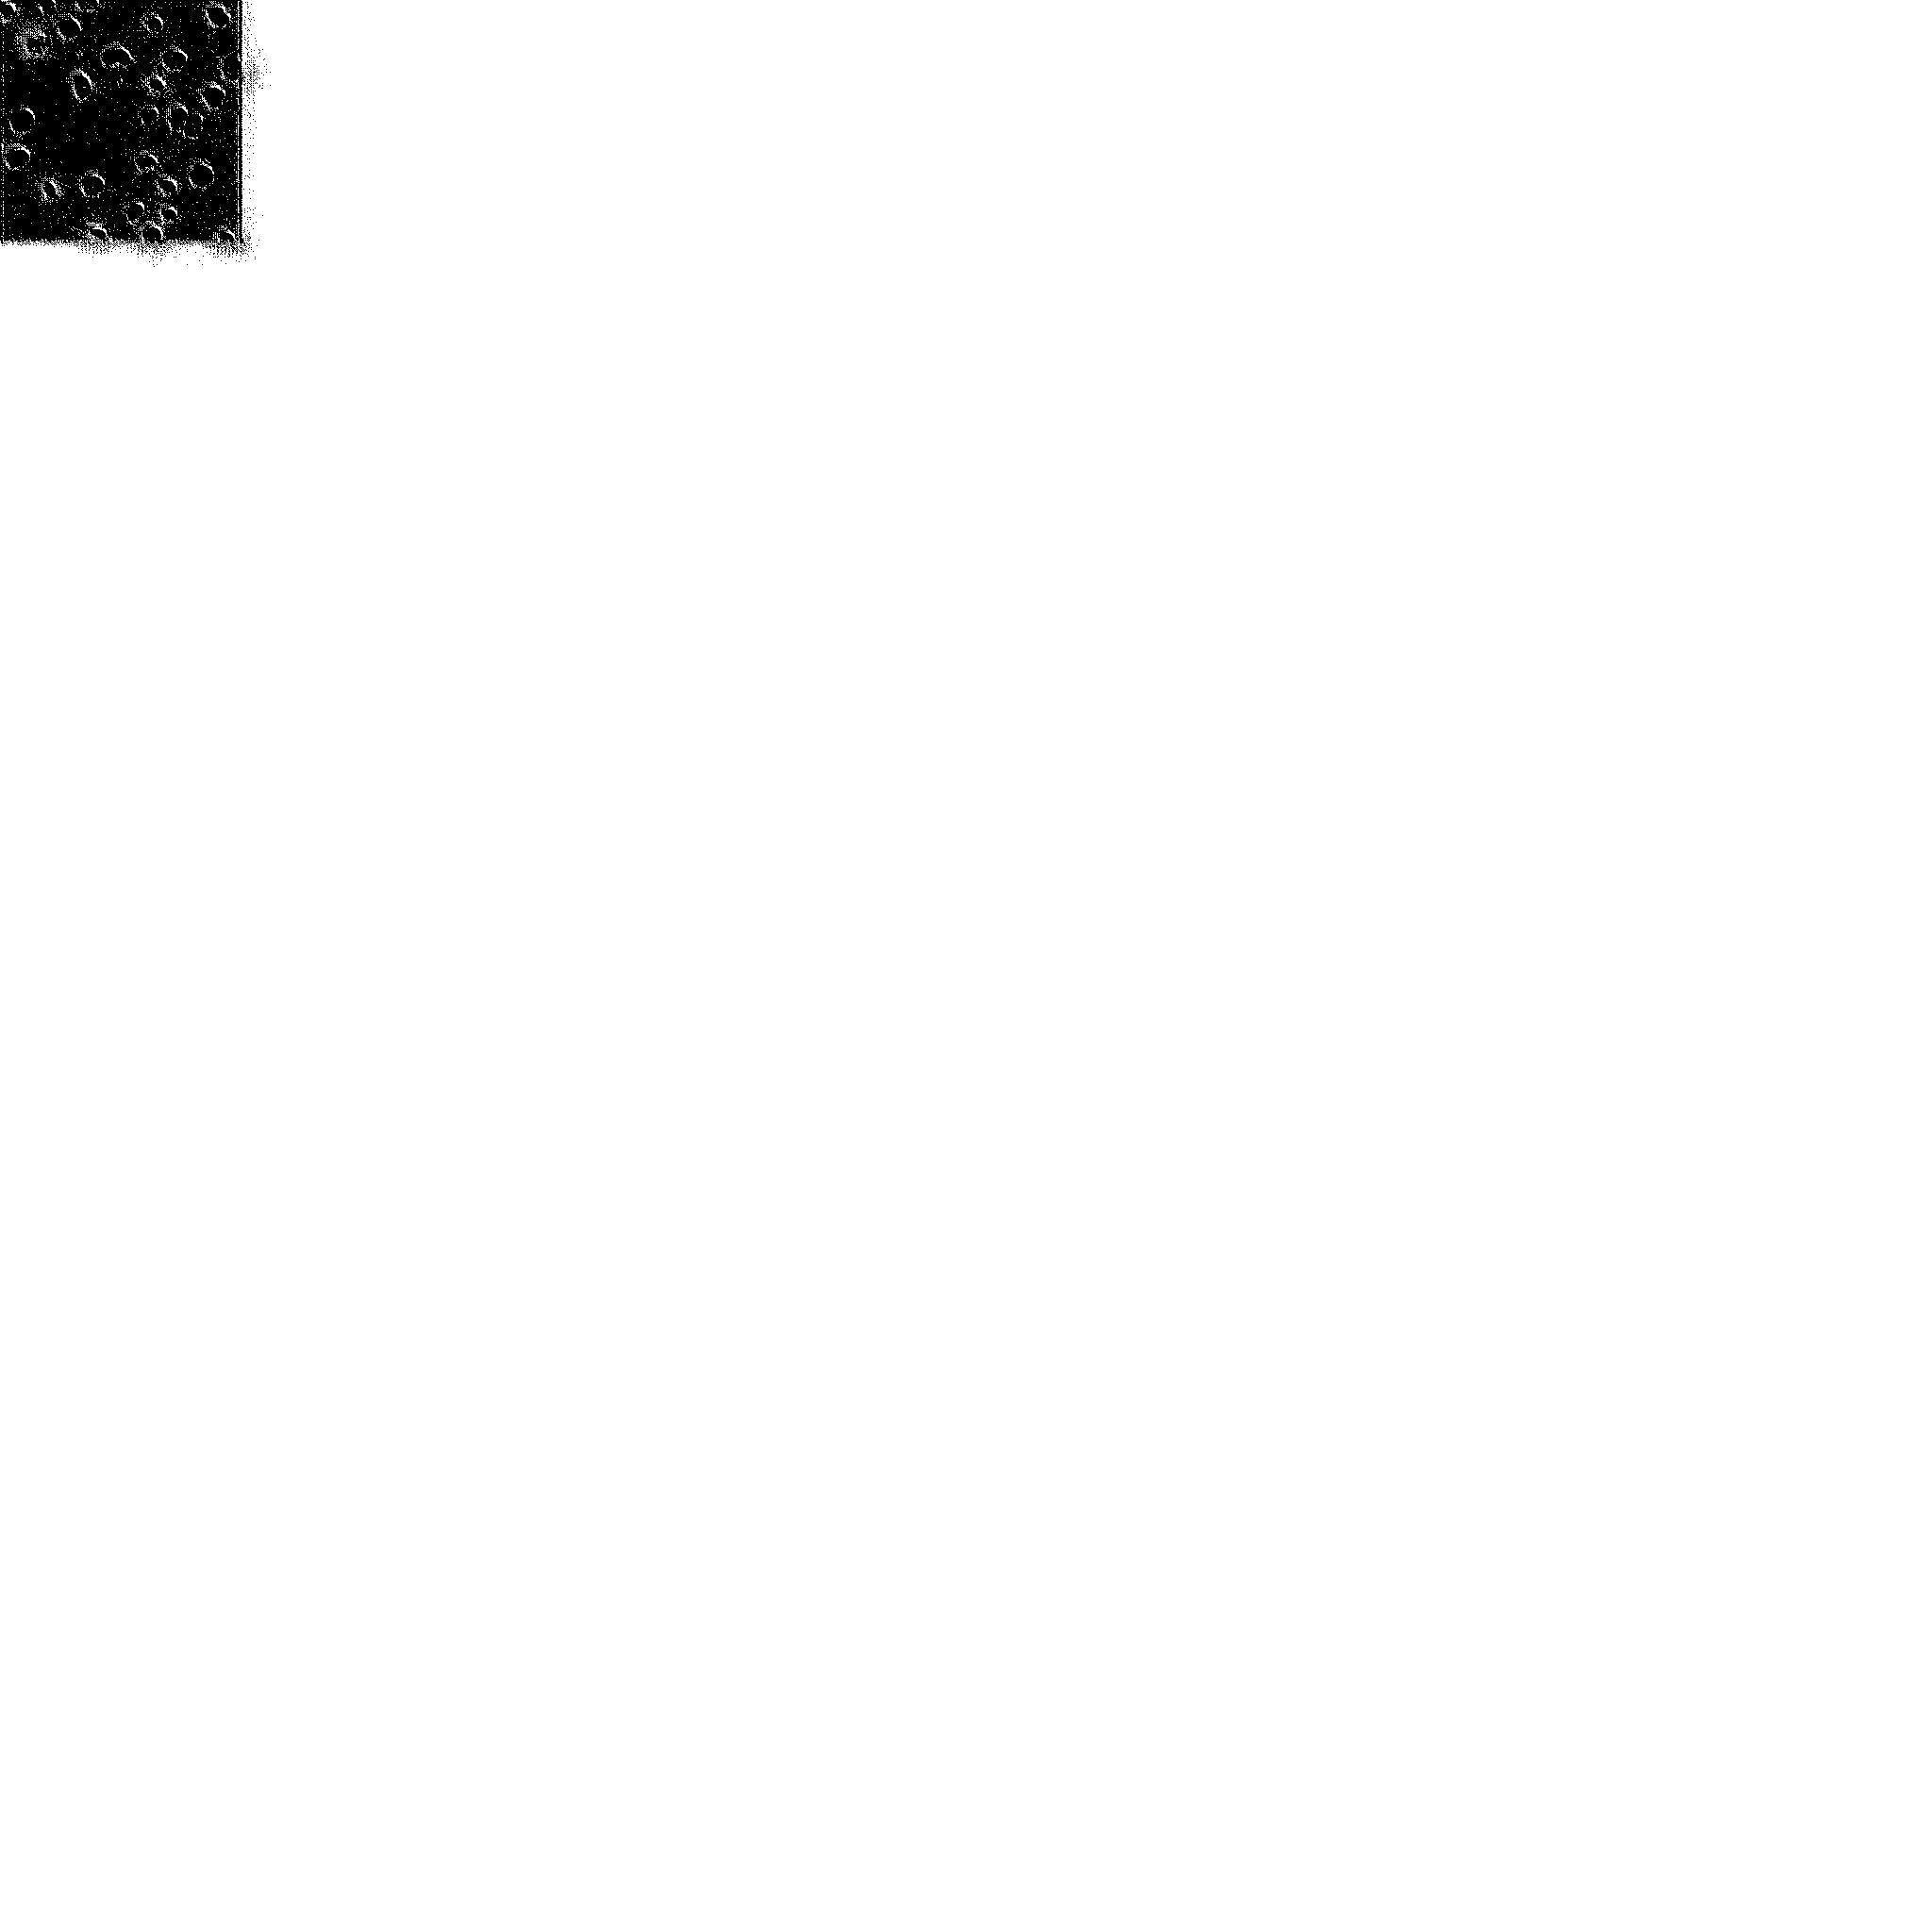

In [15]:
# Testing before training:
arr = model.test_step(x_train[0].to(gpu))
converted_arr = arr.where(arr == 0, 255)
np_arr = converted_arr.numpy()
uint8_arr = np_arr.astype(np.uint8)

img = Image.fromarray(uint8_arr)
img.show()

In [19]:
epochs = 100
batchs = 5

for epoch in range(epochs):
    totalLoss = model.train_model(x_train[0 : batchs], y_train[0 : batchs], optimizer)
    print(f"End epoch {epoch} with loss {totalLoss}")

End epoch 0 with loss 0.04890379309654236
End epoch 1 with loss 0.04779786989092827
End epoch 2 with loss 0.04717347398400307
End epoch 3 with loss 0.04637385904788971
End epoch 4 with loss 0.045249082148075104
End epoch 5 with loss 0.04437543824315071
End epoch 6 with loss 0.0435061901807785
End epoch 7 with loss 0.04245537891983986
End epoch 8 with loss 0.041404105722904205
End epoch 9 with loss 0.04054742306470871
End epoch 10 with loss 0.03974134102463722
End epoch 11 with loss 0.03895379602909088
End epoch 12 with loss 0.038199834525585175
End epoch 13 with loss 0.03737268224358559
End epoch 14 with loss 0.03659498319029808
End epoch 15 with loss 0.03594663366675377
End epoch 16 with loss 0.03530276566743851
End epoch 17 with loss 0.03473388031125069
End epoch 18 with loss 0.034237660467624664
End epoch 19 with loss 0.03365263342857361
End epoch 20 with loss 0.033081647008657455
End epoch 21 with loss 0.03260447829961777
End epoch 22 with loss 0.03207491338253021
End epoch 23 with

In [30]:
test_img = 17
arr = model.test_step(x_train[test_img].to(gpu))

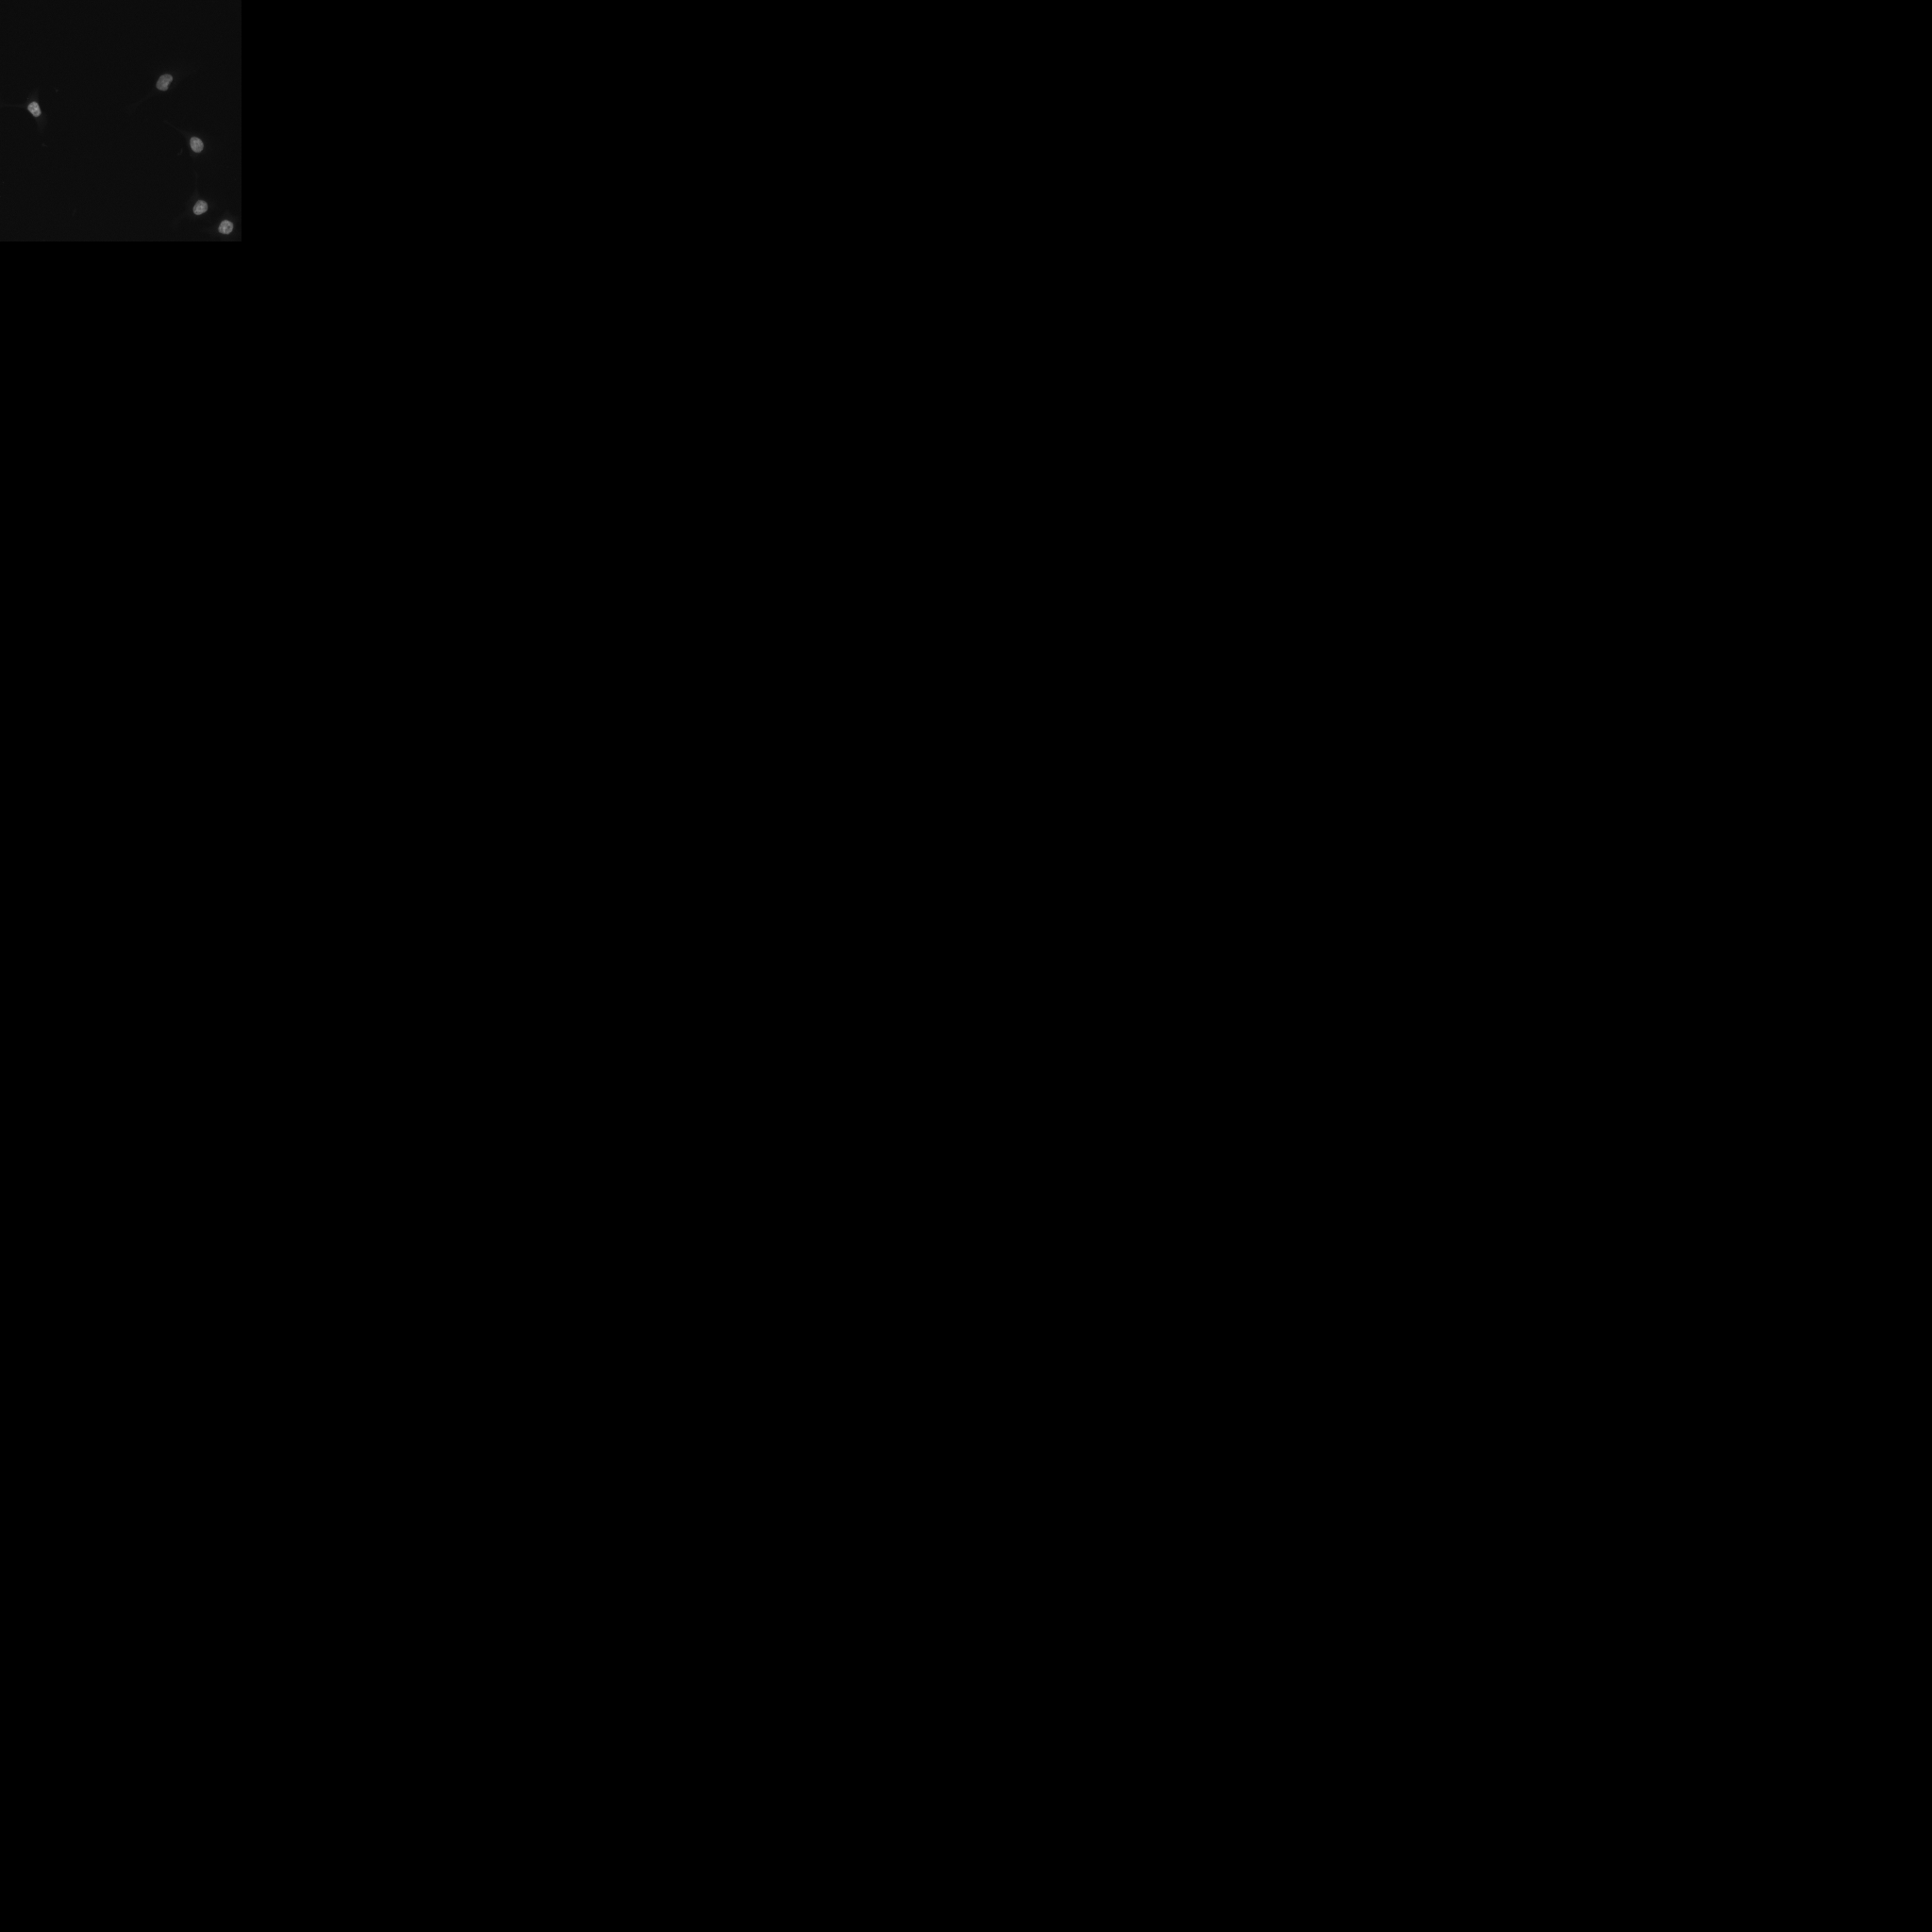

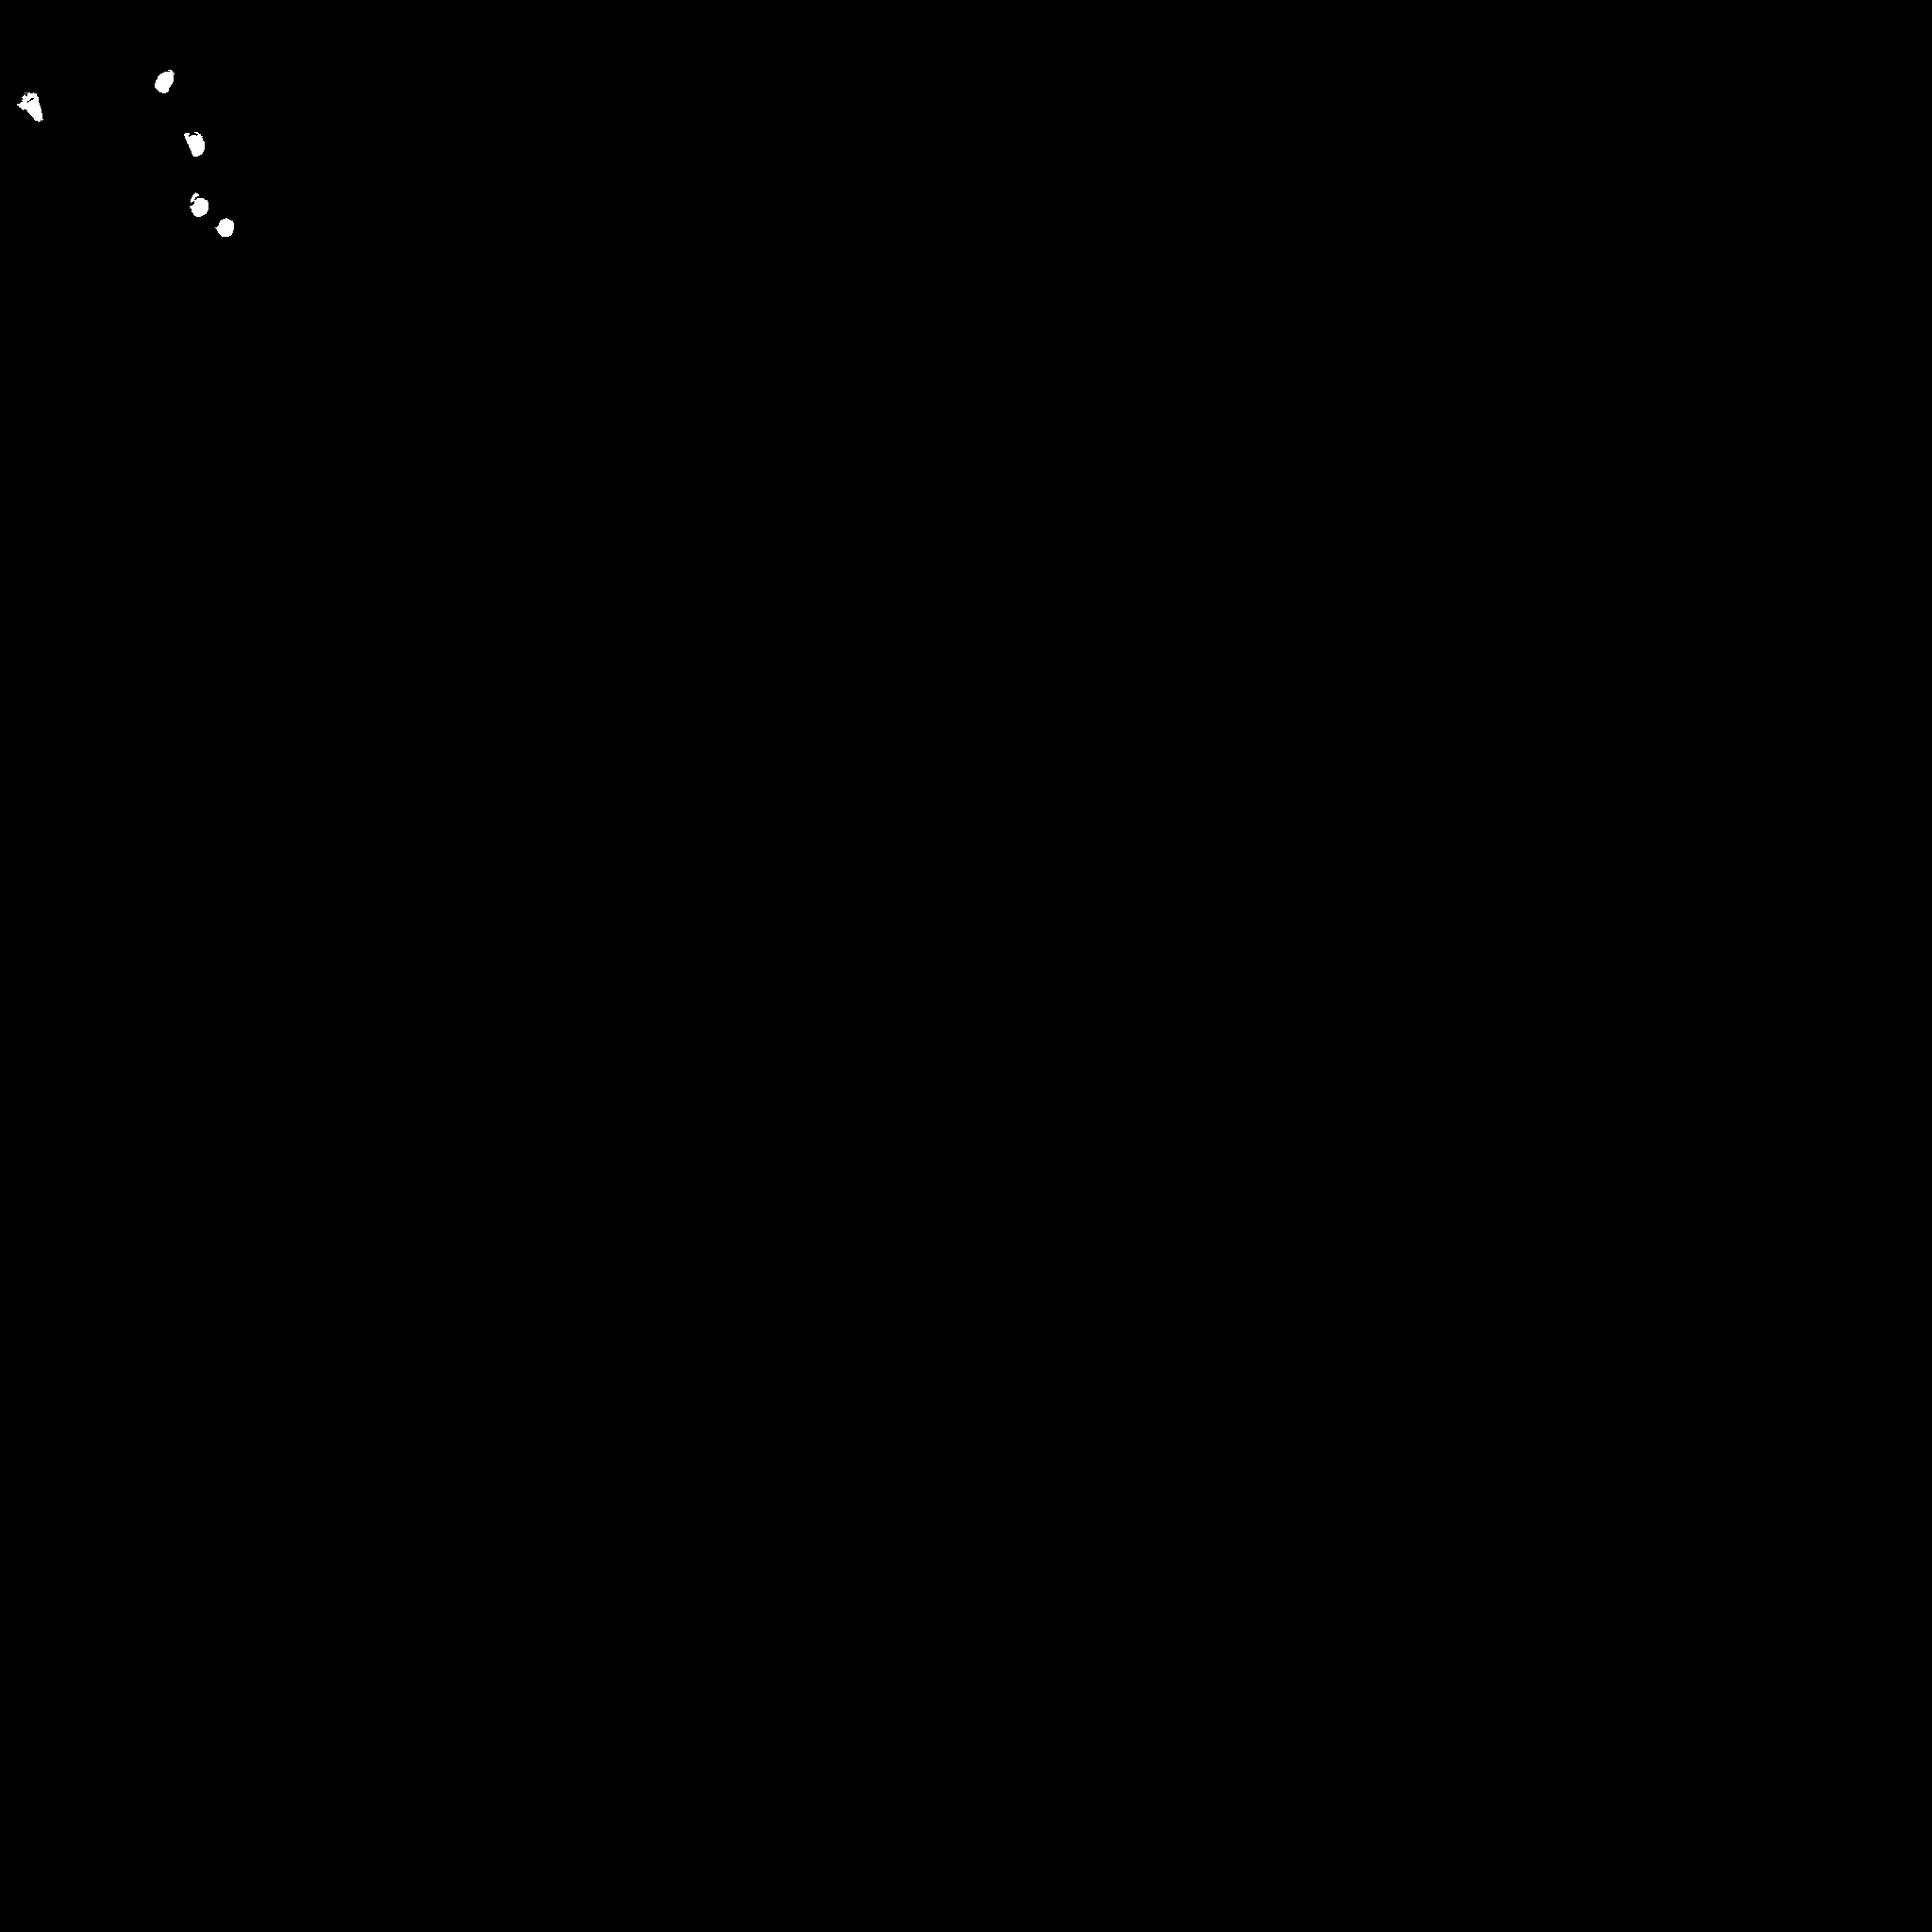

In [31]:
img = Image.fromarray(np.transpose(x_train[test_img].numpy().astype(np.uint8), (1, 2, 0)))
img.show(title="Source")

converted_arr = arr.where(arr == 0, 255)
np_arr = converted_arr.numpy()
uint8_arr = np_arr.astype(np.uint8)

img = Image.fromarray(uint8_arr)
img.show()